<a href="https://colab.research.google.com/github/hchacon4/test/blob/main/decoder11(1k_samps_area0_1_0_01)random_sparse_grid_comparison_20_pipes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Notes
- Using SimData_to_csv notebook to create dataset csv
- I may want a labels map (dict) for pipe labels like the one here
  - https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#iterating-and-visualizing-the-dataset
- Unclear what a one-hot encoded tensor might be used for
  - used here as a target label transformation
    - https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html#lambda-transforms

- How do I handle two labels?
- Is normalization required?
 - ans: desirable when features have different ranges. https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029#:~:text=The%20goal%20of%20normalization%20is,when%20features%20have%20different%20ranges.
- Complete a panda tutorial
- He: Classifer tutorial; CIFAR10 dataset (3 channel images)
 - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- Colab Pro
 - One important caveat to remember while using Colab is that the files you upload to it won’t be available forever. Colab is a temporary environment with an idle timeout of 90 minutes and an absolute timeout of 12 hours. This means that the runtime will disconnect if it has remained idle for 90 minutes, or if it has been in use for 12 hours [longer for Colab Pro]. On disconnection, you lose all your variables, states, installed packages, and files and will be connected to an entirely new and clean environment on reconnecting. source:https://neptune.ai/blog/google-colab-dealing-with-files

####Model framework

In [1]:
%matplotlib inline

import os
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

import pandas as pd   # For loading csv file dataset
import random

# Define model
#  -- when called, model returns a output_dim dimensional tensor
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_lrelu_stack = nn.Sequential(
            # Define the input dimensions
            # nn.Linear(input_dim, 256),
            nn.Linear(input_dim, 512),
            # nn.Linear(input_dim, output_dim),
            nn.LeakyReLU(),
            # nn.Linear(512, 512),
            # nn.LeakyReLU(),
            # nn.Linear(512, 512),
            # nn.LeakyReLU(),
            # nn.Linear(512, 512),
            # nn.LeakyReLU(),
            # nn.Linear(512, 512),
            # nn.LeakyReLU(),
            # nn.Linear(512, 512),
            # nn.LeakyReLU(),
            # # Define the output dimensions
            # nn.Linear(256, output_dim),
            nn.Linear(512, output_dim),
            nn.LeakyReLU(),
        )
        # Yisong: initialize the weights in the first layer, and the following layers will follow suit.
        # self.linear_lrelu_stack[0].weight.data /= 100.

    def forward(self, x):
        x = self.flatten(x)
        # print(x.size())
        logits = self.linear_lrelu_stack(x)
        return logits

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


####Training and Testing

In [2]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch=0, mod=100):
    """
    loss_fn is a list of pytorch loss functions.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)   # For avg training loss
    # print(f'train_loop(): dataset size: {size}')
    # print(f'train_loop(): num_batches: {num_batches}')
    train_loss, train_accuracy = 0, 0
    confusion_matrix = torch.zeros(20, 20, dtype=torch.int32)
    prevLoss = 100.
    for batch, (X, y) in enumerate(dataloader):
        # print(batch, X)
        # print(y)
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        # print(y.size())
        # print(pred.size())
        # print(pred)
        loss = loss_fn(pred, y)   # returns single value; avg loss across batch      
        # print(loss * len(y))
        # for i in range(len(y)) :
        #   print(pred[i])
        #   print(y[i])
        #   ls = loss_fn(pred[i], y[i])
        #   print(f'loss {i} {ls}')
        # print(y)
        # print(pred.argmax(1).type(y.dtype))
        # # Confusion Matrix
        # for i in range(len(y)) :
        #   preds = pred.argmax(1).type(y.dtype)
        #   confusion_matrix[y[i]][preds[i]] += 1
        # print(confusion_matrix)
        
        # Top-k predictions
        # torch.topk(input, k, dim=None, largest=True, sorted=True, *, out=None) -> (Tensor, LongTensor)
        k = 1
        # top_k = torch.topk(input=pred, k=k, dim=1,)
        # print(top_k)

        # Disaggregate performance -- save model
        #  goal: extract outliers (in another notebook)
        #  Make into a function.
        # if epoch > 2000 and loss.item() > (prevLoss * 15) :
        # if epoch == 10000 :
        #   print(f'train_loop(): epoch {epoch} -- loss jumped from {prevLoss:.3} to {loss.item():.3}')
        #   torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/Decoder/saved_models/d11_epoch{epoch}_{batch}_{loss.item():.3}.pt')
        # # print(prevLoss)
        # prevLoss = loss.item()
        # print(prevLoss > loss * 20)
        # print(epoch)
        # assert False

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # train_loss += loss_fn(pred, y).item() * len(y)   # I think this second call to loss_fn runs the grad twice. ???
        train_loss += loss.item() * len(y)
        # y.dtype ensures the the operand types match for use w/ comparison operator (sensitive to type)
        train_accuracy += (pred.argmax(1).type(y.dtype) == y).type(torch.float32).sum().item()
        # print(loss)

        if batch % mod == 0:
            # print(batch)
            # print(y)
            # print(pred)
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # Save last model
    # if epoch == 10000 :
    #     print(f'train_loop(): epoch {epoch} -- loss jumped from {prevLoss:.3} to {loss.item():.3}')
    #     torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/Decoder/saved_models/d11_epoch{epoch}_{batch}_{loss.item():.3}.pt')

    train_loss /= size    # weighted avg training loss
    train_accuracy /= size
    print(f"Training Error: \n Accuracy: {(100*train_accuracy):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    return train_loss, train_accuracy, confusion_matrix


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # print(f'test dataset size: {size}')
    # print(f'test num_batches: {num_batches}')
    test_loss, test_accuracy = 0, 0
    confusion_matrix = torch.zeros(20, 20, dtype=torch.int32)

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            # print(pred)
            # print(y)
            test_loss += loss_fn(pred, y).item()
            # y.dtype ensures the the operand types match for use w/ comparison operator (sensitive to type)
            test_accuracy += (pred.argmax(1).type(y.dtype) == y).type(torch.float32).sum().item()
            # Confusion matrix
            for i in range(len(y)) :
              preds = pred.argmax(1).type(y.dtype)
              confusion_matrix[y[i]][preds[i]] += 1

    test_loss /= num_batches
    test_accuracy /= size
    print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    # return test accuracy percentage for epoch
    return test_accuracy, confusion_matrix

####Animator (d2l)

In [3]:
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')

In [4]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [5]:
from matplotlib import pyplot as plt
from IPython import display

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
      
        self.nrows = nrows
        self.ncols = ncols
        self.figsize = figsize

        self.xlabel = xlabel
        self.ylabel = ylabel
        self.xlim = xlim
        self.ylim = ylim
        self.xscale = xscale
        self.yscale = yscale
        self.legend = legend

        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)

    
    def display_plt(self):
        # Borrowed use_svg_display() implementation from d2l
        use_svg_display()
        # matplot function
        self.fig, self.axes = plt.subplots(self.nrows, self.ncols, figsize=self.figsize)
        if self.nrows * self.ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments; set_axes in d2l API
        self.config_axes = lambda: set_axes(self.axes[0],
                                            self.xlabel,
                                            self.ylabel,
                                            self.xlim,
                                            self.ylim,
                                            self.xscale, self.yscale, self.legend)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

        # return self.fig

####Confusion Matrix

In [6]:
# %run /content/drive/MyDrive/'Colab Notebooks'/'Water Distribution Network'/'Input Pipeline'/'Data To File'/SimData_to_csv(hdf)_v1.ipynb
class Conf_Mat() :
  def __init__(self, classes=10) :
    """classes (int): the number of classes in the classifier."""
    self.confusion_matrix = torch.zeros(classes, classes, dtype=torch.int32)
    # Load labels via JSON or csv file.
    self.labels_str = ['P1', 'P10', 'P100', 'P1000', 'P101', 'P1016', 'P102', 'P20', 'P40', 'P1024']
  
  def addValues(self, pred, y) :
    """Add values to the confusion matrix.
    pred (tensor): tensor containing model predictions.
    y (tensor): tensor containing ground truth labels.
    return None
    """
    # Confusion Matrix
    for i in range(len(y)) :
      preds = pred.argmax(1).type(y.dtype)
      confusion_matrix[y[i]][preds[i]] += 1
    print(confusion_matrix)
  
  def displayConfMat(self) :
    pass

def decode_labels() :
  # Time consuming
  # Might be easier to place the encoder in a file and read it here.
  # WARNING: lab_subset order is not consistent.
  # NOTE: sets are not subscriptable
  # net_charac, dir_path, simdata_dir, base_file, base_jfile, simdata_dir, dest_dir, set_size, time_stamp, debug = feat_lab_args()
  # encoded_targets, lab_subset = labels_ds(base_jfile, simdata_dir, set_size, debug)
  return sorted(['P1', 'P10', 'P100', 'P1000', 'P101', 'P1016', 'P102', 'P20', 'P40', 'P1024',
                 'P39', 'P11', 'P800', 'P810', 'P446', 'P320', 'P981', 'P967', 'P942', 'P958',])
# print(decode_labels())

####Normalization

In [7]:
def norm(features) :
  # print(f'norm(): {features} size {features.size()}')
  sq_feat = features ** 2
  # print(f'norm(): {sq_feat} size {sq_feat.size()}')
  sum_feat = sq_feat.sum(1)
  # print(f'norm(): {sum_feat} size {sum_feat.size()}')
  norm_feat = torch.sqrt(sum_feat)
  # print(f'norm(): {norm_feat} size {norm_feat.size()}')
  # print(norm_feat.view(features.size(0), 1))
  unit_feat = features / norm_feat.view(features.size(0), 1)
  # print(f'norm(): {unit_feat} size {unit_feat.size()}')
  return unit_feat
# _, observed, __ = SimData(net_char=4, tmstp=80)
# norm(observed)

####Subsampling

#####Mask Generation
- (1/0) Sensing Mask Vector

In [8]:
def sensing_mask_rand(feature_vec, max_sense = 30):
  """
  preconditions: feature tensor must be flat.

  Parameters
  feature_vec: feature tensor to be masked
   shape: list of dimensions
  max_sense: randomly choose 1 to max_sense to be 1, rest 0

  returns 0/1 sensing mask tensor of shape feature_vec w/ max_sense elems set to 1 (rest 0)
  """

  # Create (0/1) mask populated w/ max_sense ones
  mask = torch.zeros(feature_vec.size()).to(device)
  # print(mask)
  # indices = torch.randint(len(feature_vec), size=(max_sense,))   # may contain fewer than max_sense unique indices
  # Katie: Randomize indices and choose the first max_sense
  indices = [*range(len(feature_vec))]
  random.shuffle(indices)
  # print(indices)
  # for idx in indices:   # for use with line 16
  for idx in indices[:max_sense]:
    mask[idx] = 1
  # print(mask)

  # Pass features through the mask
  masked_features = feature_vec * mask

  return mask, masked_features.to(device)
# feature_vec = torch.rand([100])
# print(feature_vec)
# mask, masked_feats = sensing_mask_rand(feature_vec)
# print(mask, '\n', masked_feats)

In [9]:
def sensing_mask_alternate(feature_vec):
  """
  preconditions: feature tensor must be flat.

  Parameters
  feature_vec: feature tensor to be masked

  returns 0/1 sensing mask tensor of shape feature_vec w/ even indexed elems set to 1 (rest 0)
  """

  # Create (0/1) mask populated w/ max_sense ones
  mask = torch.zeros(feature_vec.size()).to(device)
  # print(mask)
  for idx in range(0, feature_vec.size()[0], 2) :
    mask[idx] = 1
  # print(mask)

  # Pass features through the mask
  # masked_features = feature_vec * mask

  # Simplification: This version reduces the size of the feature
  #  vector by half (mask not concat).
  masked_features = feature_vec[0].reshape([1])
  for idx in range(2, feature_vec.size()[0], 2) :
    masked_features = torch.cat((masked_features, feature_vec[idx].reshape([1])))

  return mask, masked_features.to(device)
# feature_vec = torch.rand([100]).to(device)
# print(feature_vec)
# mask, masked_feats = sensing_mask_alternate(feature_vec)
# print(mask, '\n', masked_feats.size(), '\n', masked_feats)

#####Random subsamples

In [10]:
def random_subset(meas_tensor, size, seed=None) :
  """Random subset of measurements (fixed seed).
  Must be able to change the cardinality of the subset.
  Algorithm
    create list of indices
    randomize indices
    select first x number of indices (where x is the subset cardinality)
    form a tensor containing the the sample measurements matching those indices.
    return this tensor
  """
  gen = None
  if seed :
    gen = torch.Generator().manual_seed(seed)

  rand_idxs = torch.randperm(meas_tensor.size()[0], generator=gen)
  sub_idxs = rand_idxs[:size]
  # print('random_subset():', sub_idxs, sub_idxs.size())
  subset = meas_tensor[sub_idxs]
  # print(meas_tensor.size())
  return subset.to(device), sub_idxs

# Test code
# X = torch.rand(100)
# rand_sub = random_subset(X, 50, 1000)
# print('random_subset results:', rand_sub)
# print(rand_sub.size())
# assert False

In [11]:
def rand_sub_dataset(X, size, seed=None) :
  reduced_meas_X = torch.zeros([X.size(0), size]).to(device)
  # print(X.size(0))
  for i in range(len(X)) :
    rand_sub, sub_idxs = random_subset(X[i], size, seed)
    # print('random_subset results:', rand_sub)
    # print(rand_sub.size())
    reduced_meas_X[i] = rand_sub
  return reduced_meas_X, sub_idxs

# Test Code
# X = torch.rand([3, 20])
# size, seed = 10, 1000
# reduced_meas_X, sub_idxs = rand_sub_dataset(X, size, seed)
# # print(sub_idxs)
# for i, idx in enumerate(sub_idxs) :
#   # print(reduced_meas_X[0, i], X[0, idx])
#   if reduced_meas_X[0, i].item() != X[0, idx].item() :
#     raise Exception('rand_sub_dataset(): Error: Value doesnt match.')
# # print(X[0, 307], X[0, 536], X[0, 329])
# # print(reduced_meas_X[0, 0], reduced_meas_X[0, 1], reduced_meas_X[0, 2])
# print('Done!')

####Load SimData and form concat dataset

In [12]:
def SimData(net_char, tmstp) :
  """
  Note: Dataset file generated in SimData_to_csv notebook
   row 0: base_case
   rows 1->set_size: observed; one leak scenario per row; 1hr (out of one week)
   Labels included (last column)
  """

  # Load dataframe
  src_dir = '/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/Input Pipeline/Datasets/'
  leak_pip_ct = 20
  leak_pipes = f'leak_pipes_{leak_pip_ct}/'
  if tmstp :
    ts_dir = f'tmstp{tmstp}/'
  else :
    ts_dir = ''
  # NOTE: double check dataset file name
  if net_char == 0:   dataset_file = 'dataset1000_link_flowrate_area0.01_0.1.csv'
  elif net_char == 1: dataset_file = 'dataset1000_link_headloss_area0.01_0.1.cs'
  elif net_char == 2: dataset_file = 'dataset1000_link_velocity_area0.01_0.1.cs'
  elif net_char == 3: dataset_file = 'dataset1000_node_demand_area0.01_0.1.cs'
  elif net_char == 4: dataset_file = 'dataset1000_node_head_area0.01_0.1.csv'
  elif net_char == 5: dataset_file = 'dataset1000_node_pressure_area0.01_0.1.csv'
  
  data_file = src_dir + leak_pipes + ts_dir + dataset_file
  datast_ds = pd.read_csv(data_file)
  # print(datast_ds.head())
  
  # Separate base_case, raw_data, and encoded labels
  # Base Case
  base_case = torch.tensor(datast_ds.values[0, :-1], dtype=torch.float32).to(device)
  # print(base_case)
  # raw_data
  raw_data = torch.tensor(datast_ds.values[1: , :-1], dtype=torch.float32).to(device)
  print(f'SimData(): raw_data {raw_data.size()}')
  # encoded labels
  labels = torch.tensor(datast_ds['Label'], dtype=torch.long)[1:].to(device)
  print(f'SimData(): labels {labels.size()}')

  return base_case, raw_data, labels
# _, __, ___ = SimData()

In [13]:
def leakpipe_subset(pipe_ct, raw, enc_labs):
  "Used to limit the number of pipes in the dataset"
  tmp_raw = torch.tensor([[0]]).to(device)   # dim trouble w/ cat
  tmp_labs = torch.tensor([0]).to(device)
  print(tmp_labs.size())

  for i in range(len(enc_labs)):
    if enc_labs[i] < pipe_ct:
      tmp_raw = torch.cat((tmp_raw, raw[i].reshape([444])))
      tmp_labs = torch.cat((tmp_labs, enc_labs[i].reshape([1])))

  return tmp_raw[1:], tmp_labs[1:]

In [14]:
def cat_net_attr(net_ls, tmstp, norm_feats=False) :
  cat_attrs = None
  for net_char in net_ls :
    # base_case, X_raw, encoded_labels
    data = SimData(net_char, tmstp)

    if not cat_attrs :
      # cat_attr = base_case, X_raw, encoded_labels
      cat_attrs = data
      cat_attrs = list(cat_attrs)   # Creates 3 elem list from data 3-tuple returned by SimData.
      if norm_feats :
        cat_attrs[1] = norm(data[1])
    else :
      # for i in range(0, len(cat_attr), 2) :
      #   cat_attr[i] = torch.cat((cat_attr[i], data[i]))
      cat_attrs[0] = torch.cat((cat_attrs[0], data[0]))
      if norm_feats :
        cat_attrs[1] = torch.cat((cat_attrs[1], norm(data[1])), dim=1)
      else :
        cat_attrs[1] = torch.cat((cat_attrs[1], data[1]), dim=1)
      # only need one set of label; no need to cat those again.
    # Normalize Features
    if norm_feats:
      # Raw data normed across all samples
      #  Would it make more sense to normalize ea sample individually?
      # X_raw = torch.nn.functional.normalize(X_raw, dim=0)
      cat_attrs[1] = norm(cat_attrs[1])
    # print(f'cat_data(): {norm_str}expected {expected.size()}')
    # print(f'cat_data(): {norm_str}expected {expected}')
  # print(cat_attrs)
  print(cat_attrs[0].size(), cat_attrs[1].size(), cat_attrs[2].size())
  return cat_attrs   # cat_attrs is a list, but can be expanded by the caller.
# _, __, ___ = cat_net_attr([0, 4], 80, True)
# print(_.size(), __.size(), ___.size())
# assert False

In [15]:
def cat_data(residual=False, norm_base=False, norm_feats=False, mask=False, net_char=[0], tmstp=None) :
  if isinstance(net_char, int) :
    net_char = [net_char]
  expected, X_raw, encoded_labels = cat_net_attr(net_char, tmstp)
  # expected, X_raw, encoded_labels = SimData(net_char, tmstp)
  # print(f'cat_data(): {expected}')
  print(f'cat_data(): X_raw max {torch.max(X_raw)}, min {torch.min(X_raw)}')
  print(f'cat_data(): X_raw range {torch.max(X_raw) + abs(torch.min(X_raw))}')
  print(f'cat_data(): X_raw {X_raw.size()}')
  # print(f'cat_data(): X_raw {X_raw[0]}')
  # print(f'cat_data(): expected {expected}')
  
  # work in progress
  # X_raw, encoded_labels = leakpipe_subset(10, X_raw, encoded_labels)
  # print(f'cat_data: encoded labels \n{encoded_labels}')
  # print(f'cat_data: encoded labels {encoded_labels.size()}')
  # assert False

  X_cat = None
  norm_str = ''   # Used for debug output
  div_by_exp = expected
  # Residual
  if residual:
    # Avoid dividing by zero
    # for idx in range(len(expected)):
      # if expected[idx] < 1.0e-12:
      #   div_by_exp[idx] = 1.0e-10
    # X_raw = X_raw / div_by_exp
    X_raw -= expected
    # expected /= expected   # might divide by zero
    # pass
  # print(f'cat_data(): X_raw {X_raw[0]}')
  
  # Normalizations
  if norm_base:
    # Normalize expected
    #  orders of magnitude larger than residual data
    #  v = v / max(||v||_p, epsilon)  where epsilon is a small value that void dividing by zero
    # norm_expected = torch.nn.functional.normalize(expected.reshape([1,-1]))
    expected = torch.nn.functional.normalize(expected, dim=0) * 10.0
    norm_str = 'norm_'
  # if norm_feats:
  #   # Raw data normed across all samples
  #   #  Would it make more sense to normalize ea sample individually?
  #   # X_raw = torch.nn.functional.normalize(X_raw, dim=0)
  #   X_raw = norm(X_raw)
  # print(f'cat_data(): {norm_str}expected {expected.size()}')
  # # print(f'cat_data(): {norm_str}expected {expected}')

  # I think I can move if mask outter and elim the for loop.
  for feature_vec in X_raw:
    if mask :
      # Mask and masked features
      #  May want sensing_mask_rand() that can process batches of samples
      # mask_tn, masked_feats = sensing_mask_rand(feature_vec)
      # Construct feature set from concatination of expected, mask, and masked measuremnts.
      # temp = torch.cat((masked_feats.to(device), mask.to(device), expected.to(device))).reshape([1,-1])
      # Expected measurements not included
      # temp = torch.cat((masked_feats.to(device), mask_tn.to(device))).reshape([1, -1])
      # Simplification: notice feature vector size is halved. Update col variable accordingly.
      mask_tn, masked_feats = sensing_mask_alternate(feature_vec)
      # Not Needed. Adjust size of label vector.
      # masked_labels = encoded_labels[0].reshape([1])
      # print(encoded_labels.size())
      # assert False
      # for idx in range(2, encoded_labels.size()[0], 2) :
      #   masked_labels = torch.cat((masked_labels, encoded_labels[idx].reshape([1])))
      temp = masked_feats.reshape([1,-1])
      # encoded_labels = masked_labels
      # print(f'cat_data(), mask: enc_lab size {encoded_labels.size()}')

    else :
      # Features (no mask)
      # Construct feature set from concatination of expected and observed measuremnts.
      # temp = torch.cat((feature_vec.to(device), expected.to(device))).reshape([1,-1])
      temp = feature_vec.reshape([1,-1])
    # print(f'cat_data(): temp {temp}')

    if X_cat is None:
      X_cat = temp
      # print(X_cat)
    else:  
      X_cat = torch.cat((X_cat, temp))
      # print(X_cat)

  print(f'cat_data(): X_cat {X_cat.size()}')
  # print(f'cat_data(): X_cat {X_cat[0]}')
  # assert False
  return X_cat, encoded_labels
# print(f'output: {cat_data(residual=True, norm_exp=False, norm_feats=False, mask=False)}')
# assert False

####Train the model

#####Set-up Training

In [16]:
rows = 0
cols = 0
input_dim = 0
output_dim = 0

tr_dataset = None
ts_dataset = None

In [17]:
from collections import Counter
import statistics as stats

def histo_pipe_dist(labels) :
  """Display histogram of leakpipe distribution.
  labels (tensor) : pytorch tensor of labels (ints).
  Note: requires matplotlib and Pandas.
  """
  # Histo
  Y = pd.Series(labels.cpu())
  recounted = Counter(Y)
  print(recounted)
  std = stats.stdev(recounted.values())
  print(f'stdev {std:.2}')
  Y.plot.hist(grid=True, bins=10, alpha=0.7, rwidth=0.8, color='#607c8e', align='mid')
  plt.title(f'Label Frequency for {len(Y)} Samples')
  plt.xlabel('Label')
  plt.grid(axis='x')
  # plt.text(6, 200, r'class 5 = 229 (46%)')
  # assert False
  return std

In [18]:
def randomize_dataset(X, y) :
  random.seed(10343)
  ls = []
  for i in range(len(y)) :
    zipped = X[i], y[i]
    # print(zipped, end=" ")
    ls.append(zipped)
  # print('randomize_dataset(): ls', len(ls))
  random.shuffle(ls)
  shuf_X = torch.empty([1, len(X[0])]).to(device)
  # print(shuf_X.size(), shuf_X)
  shuf_y = torch.empty([1], dtype=torch.long).to(device)
  # print(shuf_X.size(), shuf_X)
  for feat, label in ls :
    # print('randomize_dataset(): feat', feat.reshape([1, -1]).size())
    shuf_X = torch.cat((shuf_X, feat.reshape([1, -1])))
    # print('randomize_dataset(): label', label.reshape([1]).size())
    # label = torch.tensor(label, dtype=torch.long).to(device)
    shuf_y = torch.cat( (shuf_y, label.reshape([1])) )
  # print(shuf_X)
  # print(shuf_y)
  # print('randomize_dataset(): shuf_X', shuf_X.size())
  # print('randomize_dataset(): shuf_y', shuf_y.size())
  return shuf_X[1:], shuf_y[1:]

In [19]:
def find_seed(X, y, tr_size, tr_or_ts) :
  min_std = 100
  # tr_or_ts = 0  # tr = 0, ts = 1
  for i in range(20, 150) :
    print(i)
    subsets = torch.utils.data.random_split(TensorDataset(X, y),
                                            [tr_size, len(y) - tr_size],
                                            generator=torch.Generator().manual_seed(i),
                                            )
    # print(len(subsets),
    #       subsets[1].dataset.tensors[1].size(),
    #       type(subsets[1].indices),
    #       len(subsets[1].indices),
    #       subsets[1].dataset.tensors[1][[i for i in subsets[1].indices]],
    #       )
    std = histo_pipe_dist(subsets[tr_or_ts].dataset.tensors[1][[i for i in subsets[tr_or_ts].indices]])
    if std < min_std :
      min_std = std
      seed = i
  print(seed)
  return seed

#####MNISTfashion set

In [20]:
# mnist
"""
tr_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

ts_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

rows = 28
cols = 28
input_dim = rows*cols
output_dim = 10

learning_rate = 1e-3
epochs = 10
batch_size = 64
mod = 100
#"""

'\ntr_dataset = datasets.FashionMNIST(\n    root="data",\n    train=True,\n    download=True,\n    transform=transforms.ToTensor()\n)\n\nts_dataset = datasets.FashionMNIST(\n    root="data",\n    train=False,\n    download=True,\n    transform=transforms.ToTensor()\n)\n\nrows = 28\ncols = 28\ninput_dim = rows*cols\noutput_dim = 10\n\nlearning_rate = 1e-3\nepochs = 10\nbatch_size = 64\nmod = 100\n#'

#####SimData

SimData(): raw_data torch.Size([1000, 444])
SimData(): labels torch.Size([1000])
SimData(): raw_data torch.Size([1000, 396])
SimData(): labels torch.Size([1000])
torch.Size([840]) torch.Size([1000, 840]) torch.Size([1000])
cat_data(): X_raw max 152.2197723388672, min -0.19309654831886292
cat_data(): X_raw range 152.41287231445312
cat_data(): X_raw torch.Size([1000, 840])
cat_data(): X_cat torch.Size([1000, 840])
subsample: size  8
subsample: torch.Size([1000, 8])
chosen seed = 135
Counter({5: 46, 18: 41, 1: 39, 14: 37, 11: 37, 10: 37, 0: 36, 8: 35, 12: 35, 2: 35, 13: 35, 3: 35, 9: 34, 4: 33, 17: 33, 7: 31, 15: 31, 19: 31, 16: 30, 6: 29})
stdev 4.0
cols 8
Decoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_lrelu_stack): Sequential(
    (0): Linear(in_features=8, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=20, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
)


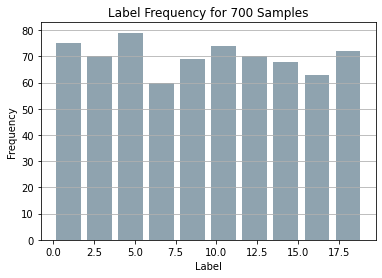

In [21]:
# Network characterist options:
#  {0: '/link_flowrate', 1: '/link_headloss', 2: '/link_velocity',
#   3: '/node_demand', 4: '/node_head', 5: '/node_pressure'}
residual = True
norm_exp = False
norm_feats = True
mask = False
net_char = 0
tmstp = 80
cat_attrs = True
subsample = True
if cat_attrs :
  net_char = [0, 4]
X, y = cat_data(residual, norm_exp, norm_feats, mask, net_char, tmstp)
# print(y)
torch.set_printoptions(edgeitems=50)
# print(f'Training Set: X[0] {X[0]}')

# Visualize the dataset leak pipe distribution.
# histo_pipe_dist(y)

if subsample :
  perc_of_meas = 0.01
  size = int(X.size(1) * perc_of_meas)
  print('subsample: size ', size)
  seed = 1001
  reduced_meas_X, __ = rand_sub_dataset(X, size, seed)
  print('subsample:', reduced_meas_X.size())
  # print(X[0, 307], X[0, 536], X[0, 329])
  # print(reduced_meas_X[0, 0], reduced_meas_X[0, 1], reduced_meas_X[0, 2])
  X = reduced_meas_X

torch.set_printoptions(edgeitems=3)
tr_size = int(len(X)*0.7)
ts_size = len(y) - tr_size
# tr_dataset = TensorDataset(X[:split_idx], y[:split_idx])
# ts_dataset = TensorDataset(X[split_idx:], y[split_idx:])
# Find a seed that creates a training set pipe distribution with smallest stdev.
seed = 135
# seed = find_seed(X, y, tr_size, 0)
print(f'chosen seed = {seed}')
# assert False
tr_dataset, ts_dataset = torch.utils.data.random_split(TensorDataset(X, y),
                                        [tr_size, ts_size],
                                        generator=torch.Generator().manual_seed(seed),
                                        )

# X, y = randomize_dataset(X, y)
# histo_pipe_dist(y[:split_idx])
# histo_pipe_dist(y[split_idx:])
idx = tr_dataset.indices
histo_pipe_dist(tr_dataset.dataset.tensors[1][[i for i in idx]])

# Determine learning rate and measurement vector size
if net_char == 0:
  # link_flowrate
  cols = 444   # links = 444; junctions = 396
  # learning_rate = 9e-3   # single layer
  learning_rate = 8e-2
if net_char == 2:
  # link_velocity
  cols = 444   # links = 444; junctions = 396
  learning_rate = 2e-7
elif net_char == 3:
  # node_demand
  cols = 396   # links = 444; junctions = 396
  learning_rate = 2e-6
  epochs = 2000
elif net_char == 4:
  # node_head
  cols = 396   # links = 444; junctions = 396
  learning_rate = 7e-2
  epochs = 2000
elif net_char == 5:
  # node_pressure
  cols = 396   # links = 444; junctions = 396
  learning_rate = 1e-3
elif isinstance(net_char, list) :
  if norm_feats and cat_attrs :
    learning_rate = 2e-2
  else :
    learning_rate = 8e-2   #(f, h, nf, nh, f+h)

# Determine number of concatenated vectors. Used for determining input_dim
concats = 1
if mask :
  concats = 1

elif norm_feats :
  pass
# Simplification adjustments
cols = X.size(1)
print(f'cols {cols}')


rows = 1
input_dim = rows*cols*concats
output_dim = 20
epochs = 20000
batch_size = 128
mod = 5

# Instantiate model framework
model = Decoder(input_dim, output_dim).to(device)
print(model)
# print(*model.parameters())

#####Training

In [22]:
# Initialize the loss function
#  nn.CrossEntropyLoss() encapsulates nn.LogSoftmax and nn.NLLLoss
loss_fn = nn.CrossEntropyLoss()
# Parameter adjustment protocol
# He: always start w/ Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For plotting results
animator = Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0.0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_dataloader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False)
    # for x,y in train_dataloader:
    #   print(x,y)
    #   break
    tr_loss, __, _ConfM_ = train_loop(train_dataloader, model, loss_fn, optimizer, epoch=t+1, mod=mod)
    train_metrics = (tr_loss, __)

    # Disaggregate data -- save models; note epoch
    # if t > 2000 and tr_loss > prevLoss * 10 :
    #   print(f'train_loop(): epoch {t} -- loss jumped from {prevLoss:.3} to {tr_loss:.3}')
    #   torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/Decoder/saved_models/d11_epoch{t}.pt')
    # prevLoss = tr_loss

    test_dataloader = DataLoader(ts_dataset, batch_size=batch_size)
    test_acc, confusion_matrix = test_loop(test_dataloader, model, loss_fn)
    # animator
    animator.add(t + 1, train_metrics + (test_acc,))
# Not sure the following block is necessary
# train_loss, train_acc = train_metrics
# assert train_loss < 0.5, train_loss
# assert train_acc <= 1 and train_acc > 0.7, train_acc
# assert test_acc <= 1 and test_acc > 0.7, test_acc
print("Done!")

Epoch 1
-------------------------------
loss: 2.982670  [    0/  700]
loss: 2.778851  [  300/  700]
Training Error: 
 Accuracy: 11.0%, Avg loss: 2.964360 

Test Error: 
 Accuracy: 15.0%, Avg loss: 2.798735 

Epoch 2
-------------------------------
loss: 2.737840  [    0/  700]
loss: 2.539894  [  300/  700]
Training Error: 
 Accuracy: 15.7%, Avg loss: 2.711545 

Test Error: 
 Accuracy: 14.0%, Avg loss: 2.673264 

Epoch 3
-------------------------------
loss: 2.473362  [    0/  700]
loss: 2.514197  [  300/  700]
Training Error: 
 Accuracy: 18.1%, Avg loss: 2.589089 

Test Error: 
 Accuracy: 15.3%, Avg loss: 2.613080 

Epoch 4
-------------------------------
loss: 2.370465  [    0/  700]
loss: 2.408095  [  300/  700]
Training Error: 
 Accuracy: 17.9%, Avg loss: 2.524106 

Test Error: 
 Accuracy: 23.3%, Avg loss: 2.547852 

Epoch 5
-------------------------------
loss: 2.323386  [    0/  700]
loss: 2.387059  [  300/  700]
Training Error: 
 Accuracy: 22.0%, Avg loss: 2.468659 

Test Error: 

KeyboardInterrupt: ignored

In [ ]:
# %matplotlib inline
import numpy as np

animator.display_plt()
# Automate improved filename description.
animator.fig.savefig('loss.png', bbox_inches='tight')
# plt.savefig('loss.png', bbox_inches='tight')   # Less specific. Targets active figure.

# pipe labels are located in data to csv notebook
# predictions = [f'{i}' for i in range(output_dim)]
predictions = decode_labels()
# labels = range(output_dim)
labels = decode_labels()   # Update label list
fig, ax = plt.subplots(1, 1, figsize=(4,4))
# fig.set_facecolor('#7d7f7c')
im = ax.imshow(confusion_matrix)
ax.set_xticks(np.arange(len(predictions)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(predictions)
ax.set_yticklabels(labels)

# Set-up for white grid lines on minor ticks. Creates spacing effect.
ax.set_xticks(np.arange(len(predictions)+1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(labels)+1) - 0.5, minor=True)
# Print white grid to space out the squares.
ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
# Remove spines for clarity.
for k, v in ax.spines.items() :
  v.set_visible(False)
# ax.spines['top'].set_visible(False)   # Can't slice a dictionary.
ax.tick_params(which="minor", bottom=False, left=False)

# Horizontal labeling displays on top
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
# Rotate tick labels and set alignment.
plt.setp(ax.get_xticklabels(), rotation=-45, ha='right', rotation_mode='anchor')
plt.xlabel(f'Predictions -- {ts_size}')
# Move the x labels to the top
ax.xaxis.set_label_position('top')
plt.ylabel('Labels')
# Annotate matrix with values by looping over data dimensions
for i in range(len(labels)) :
  for j in range(len(predictions)) :
    text = ax.text(j, i, confusion_matrix[i, j].item(),
                   ha='center', va='center', color='white')

ax.set_title(f'Confusion Matrix -- Epoch {t+1}')
fig.tight_layout()
# Save to file that is replaced on every run.
fig.savefig('conf.png')
# plt.show()
# plt.close()

####Sanity Check: Pass a sample to the model

In [ ]:
def predict_ch3(net, sample, samp_idx=0):
    """Predict labels (redefined from d2l Chapter 3.6.7)."""
    print('Model Evaluation')
    X, y = sample[samp_idx]
    X = X.reshape([1,-1])
    preds = net(X).argmax(axis=1)
    print(f'Scenario {samp_idx} (pred={preds.item()}, label={y.item()})')

predict_ch3(model, tr_dataset, samp_idx=28)

In [ ]:
# Test trained model on time stamps it hasn't seen before
tmstp = 168
X, y = cat_data(residual, norm_exp, norm_feats, mask, net_char, tmstp)
ts_dataset = TensorDataset(X, y)

test_dataloader = DataLoader(ts_dataset, batch_size=batch_size)
test_acc = test_loop(test_dataloader, model, loss_fn)

####Scratch Work

In [27]:
print( torch.log(torch.exp(torch.tensor(1))) )

tensor(1.)


In [ ]:
def f1(l_list) :
  for l in l_list :
    print(l)

f1((1,2))

In [ ]:
t = torch.rand(10, generator=torch.Generator().manual_seed(10))
print(' t:', t)
idxs = torch.randperm(5, generator=torch.Generator().manual_seed(10))
print(idxs)
tn = t[idxs]
print(' t:', t)
print('tn:', tn)
print(' t:', t[2])
print('tn:', tn[0])

In [ ]:
y_hat = torch.arange(20).reshape([2, -1])
print(y_hat)
len(y_hat)
print(y_hat.sum(1))
print(y_hat.argmax(dim=0))
print(y_hat.argmax(dim=1))
data = [[1.0, 1.0], [1.0, 1.0]] * 2   # multiplies the number of elements (like if you had 2 apples and then multiplied them by 2; you now have four apples)
print(data)
# print(data / data)   # dividing a list is not defined
(1,2) + (3,)   # cats the three elems
len((1,2))   # tuples have __len__ defined
[[] for _ in range(3)]
rows = [[1,1]]
print(rows)
[rows.append(i) for i in [[3,3],[4,4]]]
print(rows)

In [ ]:
# X_masked = None
# masked_feats = torch.rand(15)
# print(masked_feats)
# mask = torch.randint(2, [15])
# print(mask)
# # Mask and masked features
# # May want sensing_mask_rand() to process batches of samples
# for i in range(5):
#   temp = torch.cat((masked_feats, mask)).reshape([1,-1])
#   print(temp)

#   if X_masked is None:
#     X_masked = temp   
#     print(X_masked)
#   else:  
#     X_masked = torch.cat((X_masked, temp))
#     print(X_masked)

# for i in X_masked:
#   print(i)

In [ ]:
# size = [100,]
# K = 20
# tn = torch.zeros(size)
# mask = torch.zeros(tn.size())
# print(mask.size())
# print(mask)
# indices = torch.randint(len(tn), size=(K,))
# print(indices)
# for idx in indices:
#   mask[idx] = 1
# print(mask)

# mask = torch.cuda.FloatTensor(3, 3).uniform_()
# # tensor of floats
# mask = torch.FloatTensor(3,3).uniform_()
# print(mask)
# # tensor of booleans (?? how ??)
# mask = torch.FloatTensor(3,3).uniform_() > 0.8
# print(mask)

In [ ]:
# converting string labs to labels ranging from 0 -> num_of_classes (i.e. possible leak locations)
#  what if not all of the possible leak locations are used?
#  1) I can set the output dim to len of label_subset (easiser)
#  2) I can force the set to be all the possible fixed pipe locations (coordinating this will be tricky)
# labs = [1,2,2,3,1,4,4,3]
# lab_dict = {}
# encoded_labs = []
# label_subset = set(labs)
# print(label_subset)
# print(type(label_subset))
# print(len(label_subset))
# for i, key in enumerate(label_subset):
#   lab_dict[key] = i
# print(lab_dict)
# for key in labs:
#   encoded_labs.append(lab_dict[key])
# print(encoded_labs)

In [ ]:
# Reshaping practice
# base_file = 'simdata/_base_/node_demand.csv'
# data_file = base_file
# data = pd.read_csv(data_file)
# data_tn = torch.tensor(data.values, dtype=torch.float32)
# data_tn[:,1:].reshape([1,-1])

# data_tn = torch.arange(20).reshape([4,5])
# print(data_tn)
# data_tn = data_tn[:,1:].reshape([1,-1])
# print(data_tn)
# data_tn1 = torch.arange(20).reshape([4,5])
# print(data_tn1)
# data_tn1 = data_tn1[:,1:].reshape([1, -1])
# print(data_tn1)
# torch.cat((data_tn1, data_tn))

In [ ]:
# Extracting an intelligible answer from the model
# x = torch.arange(16, dtype=torch.float32).reshape((4,4))
# print(x)
# print(x.sum(axis=0))
# print(x.sum(axis=[0,1]))
# mean = x.sum() / x.numel()
# print(mean)
# # notice we keep all dims (tensor of a tensor ie. two brackets) vs above we lost one (just a tensor)
# print(x.sum(dim=0, keepdim=True))

# y = torch.tensor([3,3,3,3])
# # x.argmax(1).type(y.dtype) == y
# correct = 0
# correct += (x.argmax(1).type(y.dtype) == y).type(torch.float32).sum().item()
# correct

In [ ]:
# Handy timer class
class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [ ]:
# Target transform
from torchvision.transforms import Lambda

train_size = 700
# target_transform = Lambda(lambda y: torch.zeros(
#     (train_size, output_dim), dtype=torch.float).scatter_(
#         dim=1, index=torch.randint(low=0,high=output_dim,size=[train_size,1]), value=1))

# one-hot classification label vector
target_transform = Lambda(lambda y: torch.scatter_(
        dim=1, index=torch.randint(low=0,high=output_dim,size=[train_size,1]), value=1))